## Figure 8: (Multiple night observations from Figure 4 inputted into Find_Orb)

##### This notebook reproduces the analysis used to generate Figure 8, row 2, implementing the equations presented in Section 2.1 of Maryann et al. (2025) for a sample of 10 asteroids observed at the same timestamp used in Figure 4. We selected 10 out of the original 20 objects to ensure that all observations were above the horizon and unaffected by daylight, thus allowing a clean and consistent comparison.

##### We apply both the linear model in Equation 1 (column 1 of the final plot) and the quadratic model in Equation 5 (column 2 of the final plot) to evaluate how each formulation behaves over long observational arcs, and to determine which model is necessary for accurate topocentric parallax analysis when compared with Find_Orb. 

##### Later in the notebook, we convert the Horizons astrometry into MPC-format .obs files for Find_Orb and compare the distances derived from the orbit determination software with those computed directly from Equation 5 in the manuscript's Section 4 text. We conclude that over long time spans, the linear term becomes unnecessary, as the asteroid’s apparent motion is effectively non-linear within the observational window.

##### Step 1: Here we import all the packages used throughout the notebook:

In [5]:
# For numerical arrays and dataframes.
import numpy as np
import pandas as pd

# For handling plotting and axis formatting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# For custom subplot layouts
from matplotlib.gridspec import GridSpec

# Tools for fitting functions to data
from astropy.modeling import models, fitting
from scipy.optimize import curve_fit

# For file handling and regular expressions
import re
import os
from pathlib import Path
import shutil

# Access to trigonometric functions and constants.
import math

# For generating random numbers
import random

# For custom legends
from matplotlib.lines import Line2D

# Text & encoding utilities
import unicodedata

# Astronomy-specific tools (Astropy)
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import Angle

# Date & time utilities
from datetime import datetime

##### Step 2: Reading and Extracting the raw data of the 10 asteroids from the NASA JPL Horizon System

In [10]:
# txt_files_folder  = where the Horizons .txt files are stored
# csv_output_folder = where the converted .csv files will be saved
txt_files_folder  = '/hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night'
csv_output_folder = '/hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files'

# os.makedirs(): creates the above folder if it does not exist.
if not os.path.exists(csv_output_folder):
    os.makedirs(csv_output_folder)
    print(f"Created output folder: {csv_output_folder}")

# In the DataFrame's list, the following are the column headers. The blanks denoted by '' correspond to columns that are not required in the analysis. 
# Date__(UT)__HR:MN = the time and day for each observation. 
# R.A._(ICRF), DEC__(ICRF) = The RA and DEC data of each observation in decimal format
# delta = the distance to the asteroid at each observation in astronomical units (au). We use the Horizons distance to verify the measured topocentric parallax distance in step 6, thereby confirming the measured difference from the true distance. 
# deldot = the range rate (km/sec). We do not use this column in our analysis. Still, FYI, a positive deldot indicates that an object is moving away from the observer, and a negative deldot indicates that an object is moving towards the observer.
columns = ['Date__(UT)__HR:MN', '', '', ' R.A._(ICRF)', 'DEC__(ICRF)', 'delta', 'deldot', '']

# ------- We convert the document from a .txt file to a .csv file in the following steps. pandas.DataFrame: creates a new file with the same column names as seen in the original file.

# Loops through every item in the folder to identify relevant files. 
for file_name in os.listdir(txt_files_folder):

    # The file to process must have an extension of .txt
    if file_name.endswith('.txt'):
        file_path = os.path.join(txt_files_folder, file_name)

        # We only want to extract the code between “SOE” (Start of Ephemeris) and “EOE” (End of Ephemeris), since they contain the ephemeris data. 
        start_marker = "$$SOE"
        end_marker = "$$EOE"

        # data_lines: collects the data --> row by row between SOE and EOE.
        data_lines = []
        try:

            # open: opens the file in read mode using 'r'. 
            # with: ensures that the file is closed properly after reading.
            with open(file_path, 'r') as file:

                # is_data: A Boolean flag indicating that if a row of data is under analysis and between SOE and EOE, then the data needs to be stored. 
                is_data = False

                # Iterates through every line
                for line in file:

                    # When a row of lines contains SOE, then start marker, then is_data is set to True, and beyond this line, data will be captured.
                    if start_marker in line:
                        is_data = True

                    # When a row of lines contains EOE, the end marker, then is_data is set to False, and beyond this line, data will not be captured.
                    elif end_marker in line:
                        is_data = False
                   
                    # In the case that neither marker is found, and is_data is set at true, this means that data capturing is still on-going, and hasn't reached EOE. 
                    elif is_data:

                        # .strip(): removes whitespace and sends lines to data_lines.
                        data_lines.append(line.strip())
            
            # Each line of ephemeris data that is captured is split at the commas to form string values so that they are in the form of rows and columns (lists of lists) for the .csv file. 
            data = [line.split(",") for line in data_lines]

            # max_columns: searches for the longest row and its length.
            max_columns = max(len(row) for row in data)

            # Short rows are padded with empty strings at locations that do not have data, to represent the same length as the longest row. This is to make sure that the DataFrame is being created without misaligned columns.       
            data = [row + [''] * (max_columns - len(row)) for row in data]

            # Create a DataFrame and assign the appropriate column headers.
            df = pd.DataFrame(data, columns=columns[:max_columns])

            # os.path.basename(file_path): extracts the filename
            # os.path.splitext(...)[0]: removes the .txt file extension so that a new .csv extension can be added
            base_name = os.path.splitext(file_name)[0]
            csv_file_path = os.path.join(csv_output_folder, f'{base_name}.csv')
            df.to_csv(csv_file_path, index=False)
            print(f"CSV file saved: {csv_file_path}")
            
        # Error handling: gives notification if a file is not found or if there are unexpected errors.
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/2024 YR4.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/2022 QV1.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/2024 ON.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/2024 SJ.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/2024 SR4.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/2024 RJ16.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/2024 RN15.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/2014 GL1.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/Ceres.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/2024 RO2.csv


##### Step 3: Among all the observational data for each of the 10 asteroids, which are taken over a complete day and separated by hourly observations, please select only the following rows in the ephemeris data so that only nightly observations are considered, including observations that are not affected by the Horizon limit. *Please note the observations selected in Figure 4 differ from the exact time the observations in this analysis are taken; however, the range between 8 pm - 5 am stays the same. 

In [11]:
# The three observations per night are saved in a newly created .csv file. 
csv_files_path = '/hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files'
extracted_files_path = '/hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/extracted_files'

# The following are the rows that need to be extracted.
rows_to_extract = [0, 4, 31,                   
                   32, 33, 34,                  
                   66, 67, 68,                  
                   97, 98, 99,                  
                   129, 130, 131]

os.makedirs(extracted_files_path, exist_ok=True)

for file_name in os.listdir(csv_files_path):
    if file_name.endswith('.csv'):  
        file_path = os.path.join(csv_files_path, file_name)
        csv_data = pd.read_csv(file_path)
        extracted_data = csv_data.iloc[rows_to_extract]
        
        base_name = os.path.splitext(file_name)[0]
        output_csv = os.path.join(extracted_files_path, f'{base_name}.csv')
        extracted_data.to_csv(output_csv, index=False)
        
        print(f"Extracted rows saved to: {output_csv}")
        print(extracted_data.to_string(index=True))
        print("\n" + "-"*80 + "\n")

Extracted rows saved to: /hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/extracted_files/2014 GL1.csv
     Date__(UT)__HR:MN Unnamed: 1 Unnamed: 2   R.A._(ICRF)  DEC__(ICRF)     delta    deldot  Unnamed: 7
0         2.460558e+06                     m    250.441791   -28.890433  1.000840  5.428758         NaN
4         2.460559e+06                          250.452612   -28.881682  1.001239  5.596694         NaN
31        2.460559e+06          N          m    250.540790   -28.827752  1.003752  5.198175         NaN
32        2.460560e+06                     m    250.543699   -28.825692  1.003846  5.258361         NaN
33        2.460560e+06                     m    250.546658   -28.823598  1.003942  5.313040         NaN
34        2.460560e+06                          250.549681   -28.821474  1.004038  5.359884         NaN
66        2.460561e+06                     m    250.663613   -28.758568  1.006934  5.179228         NaN
67        2.460561e+06                      

In [ ]:
##### Step 4: Verify that the columns with data that will be analyzed have been properly copied to the new .csv file. 

In [12]:
def read_horizons_file(file_path):
    try:
        # Read the .csv file
        data = pd.read_csv(file_path)

        # Shorten the original names of the columns
        column_mapping = {
            'Date__(UT)__HR:MN': 'JDUT',
            ' R.A._(ICRF)': 'RA_ICRF',  
            'DEC__(ICRF)': 'DEC_ICRF',
            'delta': 'delta'}
        data = data.rename(columns=column_mapping)

        # The four columns required for curve fitting.
        required_columns = ['JDUT', 'RA_ICRF', 'DEC_ICRF', 'delta']

        # Check that all required columns are present in the DataFrame.
        # If any are missing, raise an error to alert the user.
        if not all(col in data.columns for col in required_columns):
            raise ValueError(f"Missing one or more required columns in {file_path}")

        # Return a DataFrame containing only the needed columns in the correct order.
        return data[required_columns]
    
    except Exception as e:
        # If anything goes wrong, print an error message including the filename.
        print(f"Error reading {file_path}: {e}")

        # Return an empty DataFrame with the correct column structure. 
        return pd.DataFrame(columns=['JDUT', 'RA_ICRF', 'DEC_ICRF', 'delta'])

In [ ]:
##### Step 5: Addition of a randomly generated 20 milliarcseconds (mas) Gaussian noise to each observation in the RA and DEC. 

In [13]:
# input_file: The original file path with RA and DEC. 
# output_file: The new file path with noise added in the RA and DEC. 
input_folder  = Path("/hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/extracted_files/")
output_folder = input_folder / "with_uncertainties"

# The columns that need noise addition in the original file. 
output_folder.mkdir(parents=True, exist_ok=True)
RA_COL  = " R.A._(ICRF)"      
DEC_COL = "DEC__(ICRF)"

# # Horizons does not provide measurement uncertainties in RA and DEC. So, we randomly add 20 mas of noise to mimic real astrometric errors.
# 20 mas converted to arcseconds. 1 mas = 0.001 arcsec and 20 mas = 0.020 arcsec
# The noise is Gaussian-distributed, consistent with typical astrometric uncertainties.
# 20 mas was chosen since it is a realistic uncertainty approximation based on typical CCD astrometric performance.
SIGMA_ARCSEC = 0.020       

# converting arcseconds into degrees because RA/DEC in the original Horizons file is in degrees (1 degree = 3600"). 
SIGMA_DEG    = SIGMA_ARCSEC / 3600.0  

# A random generator. seed=42 ensures reproducible noise, where every run of the code ensures that the noise to the observations stays the same. 
rng = np.random.default_rng(seed=42)

for csv_file in input_folder.glob("*.csv"):
    # Reads the .csv into a DataFrame, where each row is an observation.
    df = pd.read_csv(csv_file)
    
    # A safety check: If RA or DEC columns are missing, stop the code and show an error.        
    if RA_COL not in df.columns or DEC_COL not in df.columns:
        print(f"⚠️ Skipping {csv_file.name}, RA/DEC not found")
        continue

    # Extract the RA and DEC columns into a NumPy array
    ra  = df[RA_COL].to_numpy(dtype=float)
    dec = df[DEC_COL].to_numpy(dtype=float)

    # Generate one random noise value per RA and DEC observation, where mean = 0, standard deviation = 20 mas in degrees, size = number of observations (48)
    ra_noise  = rng.normal(0.0, SIGMA_DEG, size=len(df))
    dec_noise = rng.normal(0.0, SIGMA_DEG, size=len(df))

    # Adds noise to each RA. 
    # % 360.0: wraps RA so that values remain within 0–360 degrees. 
    ra_new  = (ra + ra_noise) % 360.0

    # Adds noise to each DEC. 
    # Limits the DEC at -90 and +90, since it cannot exceed the poles. 
    dec_new = np.clip(dec + dec_noise, -90.0, 90.0)

    # Printing a readable header to see the comparison. 
    print(f"\n=== {csv_file.name} ===")
    print("Obs |     Original_RA     Original_DEC |    RA_noise(deg)   DEC_noise(deg) |   RA_noise(mas)   DEC_noise(mas) |          New_RA          New_DEC")
    print("----+------------------+----------------+----------------------------------+----------------------------------+---------------------------------")
    for i in range(len(df)):
        print(f"{i+1:3d} | "
              f"{ra[i]:16.8f} {dec[i]:15.8f} | "
              f"{ra_noise[i]:16.8f} {dec_noise[i]:16.8f} | "
              f"{ra_noise[i]*3600*1000:16.2f} {dec_noise[i]*3600*1000:15.2f} | "
              f"{ra_new[i]:16.8f} {dec_new[i]:16.8f}")

    # In the newly created .csv file, the original Horizons .csv file is now replaced with 20mas noise in the RA and DEC.
    df[RA_COL]  = ra_new
    df[DEC_COL] = dec_new
    out_file = output_folder / csv_file.name
    df.to_csv(out_file, index=False)
    print(f"Saved {out_file}")


=== 2014 GL1.csv ===
Obs |     Original_RA     Original_DEC |    RA_noise(deg)   DEC_noise(deg) |   RA_noise(mas)   DEC_noise(mas) |          New_RA          New_DEC
----+------------------+----------------+----------------------------------+----------------------------------+---------------------------------
  1 |     250.44179077    -28.89043259 |       0.00000169      -0.00000477 |             6.09          -17.19 |     250.44179247     -28.89043737
  2 |     250.45261221    -28.88168234 |      -0.00000578       0.00000205 |           -20.80            7.38 |     250.45260643     -28.88168029
  3 |     250.54079006    -28.82775213 |       0.00000417      -0.00000533 |            15.01          -19.18 |     250.54079423     -28.82775746
  4 |     250.54369950    -28.82569222 |       0.00000523       0.00000488 |            18.81           17.57 |     250.54370472     -28.82568733
  5 |     250.54665772    -28.82359817 |      -0.00001084      -0.00000028 |           -39.02           

##### Step 6: Adding the topocentric parallax distance from Find_Orb

In [16]:
# Here, we load the data for each of the 12 asteroids from the .csv file, which has the results of the distance measurement for each observation. 
def load_true_delta_lookup_from_wide_csv(path_to_wide_csv):
    df = pd.read_csv(path_to_wide_csv)
    numeric = df.select_dtypes(include="number")
    col_means = numeric.mean(numeric_only=True)
    lookup = {}
    for col, val in col_means.items():
        key = col if str(col).endswith(".csv") else f"{col}.csv"
        lookup[key] = float(val)
    return lookup

# The location of the distance from Find_Orb. 
TRUTH_WIDE_CSV = "/hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/Multiple Night.csv" 
true_delta_lookup = load_true_delta_lookup_from_wide_csv(TRUTH_WIDE_CSV)

##### Step 8: Distance measurement using Eqs. 1 and 5 in Section 2.1 in Maryann et al. 2025.

In [22]:
def compute_distance_in_au_with_quadratic(file_path, true_delta_lookup):

    # Read the Horizons .csv file and return only the needed columns
    data = read_horizons_file(file_path)

    # Extract columns as NumPy arrays for convenience
    JD    = data['JDUT'].values
    RA    = data['RA_ICRF'].values
    DEC   = data['DEC_ICRF'].values
    delta = data['delta'].values

    # cos(DEC): evaluated at the first observation, and used in Equation 3 to compute the correction needed to measure topocentric parallax distance
    DEC_first_row = math.cos(math.radians(DEC[0]))

    # Mean of the true distance from Horizons
    mean_delta    = float(np.mean(delta))

    # Add the data from Find_Orb
    fname    = os.path.basename(file_path)
    Find_Orb = true_delta_lookup.get(fname, np.nan)

    # Normalize RA and JD for numerical stability in the fit
    # Subtracting the minimum removes any large constant offset
    RA_min = RA.min()
    RA_normalized = RA - RA_min
    JD_min = JD.min()
    JD_normalized = JD - JD_min

    #### Polynimial (Quadratic) Fitting: Equation 5 ################################################

    # Equation: Am*sin(2πx + B) + Cx + D + Ex²
    
    # Sinusoidal term --> Am * np.sin(2 * np.pi * x + B) is the Earth's rotation (x = time; Am = amplitude of the signal, also known as the parallax signal; B = phase shift). 
    # linear + quadratic terms --> C * x + D + E * x**2 is the asteroids non-linear motion (Cx = asteroids linear motion showing a constant angular velocity; D = RA offset; E x^2 = asteroids non-linear motion due to changing geometry and orbital acceleration)
    # fit_function_polynomial defines a Python function for Eq. 5
    
    def fit_function_polynomial(x, A, B, C, D, E):
        return A * np.sin(2 * np.pi * x + B) + C * x + D + E * x**2

    # Fits the polynomial model to the normalized RA vs normalized time
    # p0 = initial guesses for Am, B, C, D, E (Best-fit parameters)
    # curve_fit() from scipy.optimize --> performs the nonlinear least-squares fit. It finds the best fit value for Am, B, C, D, and E that fit into the RA data with the 20mas noise.
    # params_sine = a NumPy array of best-fit parameter values
    # covariance_sine = 5×5 covariance matrix describing the uncertainties and correlations for Am, B, C, D, and E.
    
    params_poly, covariance_sine = curve_fit(
        fit_function_polynomial, JD_normalized, RA_normalized,
        p0=[1, 0, 0, 0, 0], maxfev=15000)
    A, B, C, D, E = params_poly

    # Convert fitted amplitude Am from degrees to radians
    A_radians_poly = np.radians(A)

    # Uncertainties in Equation 5. 
    # It is important for understanding the error propagation. 
    # np.diag(covariance_sine): extracts diagonal elements and the variances of Am, B, C, D, and E.
    # np.sqrt(...): takes the square root and gives the standard deviations (1σ uncertainties).
    sine_uncertainties = np.sqrt(np.diag(covariance_sine))
    
    # Convert the uncertainty of the fitted amplitude Am from degrees to radians
    amplitude_uncertainty_sine = np.radians(sine_uncertainties[0])

    #### Linear Fitting: Equation 1 ################################################

    # Equation: Am*sin(2πx + B) + Cx + D
    # Here, the asteroid’s motion is approximated as linear in RA. The meaning of each component is the same as seen in Eq. 5 above, and the only difference is the removal of the polynomial term/quadratic term from the analysis and the equation. 
  
    def fit_function_linear(x, A, B, C, D):
        return A * np.sin(2 * np.pi * x + B) + C * x + D

    # Fit the linear model to the same normalized data    
    params_lin, covariance_linear = curve_fit(
        fit_function_linear, JD_normalized, RA_normalized,
        p0=[1, 0, 0, 0], maxfev=15000)
    A_lin, B_lin, C_lin, D_lin = params_lin

    # Convert fitted amplitude Am_lin to radians
    A_lin_radians = np.radians(A_lin)

    # 1σ uncertainties for the linear model parameters
    linear_uncertainties = np.sqrt(np.diag(covariance_linear))

    # Convert the uncertainty of the fitted amplitude Am_lin from degrees to radians
    amplitude_uncertainty_linear = linear_uncertainties[0]

    #### Constants ################################################

    # Earth's radius in km    
    radius_of_earth_km = 6371

    # 1 au in km
    km_to_au = 149_597_870.7

    # Observatory latitude (deg) 
    latitude_deg = 30.1732
    latitude_rad = math.radians(latitude_deg)

    ### Equation 4 computed for both the linear and Quadratic Fit ################################################

    # Distance measurement concerning the center of the Earth. 
    distance_km_poly = radius_of_earth_km / A_radians_poly
    distance_uncertainty_km_poly = distance_km_poly * (amplitude_uncertainty_sine / abs(A_radians_poly))

    distance_km_lin = radius_of_earth_km / A_lin_radians
    distance_uncertainty_km_lin = distance_km_lin * (amplitude_uncertainty_linear / abs(A_lin_radians))

    #### Equation 3 computed for both the linear and quadratic Fit ###############################################
    # Since the measurements do not have an observatory's latitude or the DEC of the observations, topocentric parallax is not accounted for in the calculations. To fix this, we need two adjustments as follows: 
    
    # Latitude of the Observatory (Correction 1)
    # The observatory taking the observations of asteroid 2024 ON is the Cerro Tololo Observatory, La Serena, (code: 807) 
    # The observatory is situated at an altitude of 2200 m
    # The observatory is in the southern hemisphere of the Earth at a latitude of 30.1732° S. 
    # We convert the latitude from degrees to radians. 

    # Declination (DEC) of the observations (Correction 2)
    # Since the DEC of the observations is over two days, the change in the degrees is very small, and so we assume a single DEC value fixed at the first observation.
    
    final_distance_km_poly = (distance_km_poly * math.cos(latitude_rad)) / DEC_first_row
    final_distance_uncertainty_km_poly = final_distance_km_poly * (distance_uncertainty_km_poly / distance_km_poly)

    final_distance_km_lin = (distance_km_lin * math.cos(latitude_rad)) / DEC_first_row
    final_distance_uncertainty_km_lin = final_distance_km_lin * (distance_uncertainty_km_lin / distance_km_lin)

    #### Asteroid Distance (au) conversion from km ###################################
    
    final_distance_au_poly = final_distance_km_poly / km_to_au
    final_distance_uncertainty_au_poly = final_distance_uncertainty_km_poly / km_to_au

    final_distance_au_lin = final_distance_km_lin / km_to_au
    final_distance_uncertainty_au_lin = final_distance_uncertainty_km_lin / km_to_au

    #### Percentage Difference between True and Measured ###########
    
    # Guard against division by zero
    if mean_delta == 0 or final_distance_au_poly == 0:
        percentage_poly = 0.0
        percentage_lin  = 0.0
    else:
        percentage_poly = abs(abs(final_distance_au_poly) - abs(mean_delta)) / ((abs(final_distance_au_poly) + abs(mean_delta)) / 2) * 100.0
        percentage_lin  = abs(abs(final_distance_au_lin)  - abs(mean_delta)) / ((abs(final_distance_au_lin)  + abs(mean_delta))  / 2) * 100.0

    # Return distances and uncertainties (Eq. 5 and Eq. 1), true mean delta, percentage differences, and the fit parameters for further inspection.
    return (
        final_distance_au_poly, final_distance_uncertainty_au_poly,
        final_distance_au_lin,  final_distance_uncertainty_au_lin,
        mean_delta, 
        percentage_poly, percentage_lin,
        params_poly, params_lin, Find_Orb)

##### Step 9: Process every Horizons file and print the distance measurement to each asteroid as well as the percentage difference between the measured and Horizon distance. 

In [27]:
# This function processes every asteroid .csv file in a folder
def process_all_asteroid_files(folder_path, true_delta_lookup):
    # This list will store the full results for all asteroids.
    results = []

    # Loop through all files inside the provided folder.
    for file_name in os.listdir(folder_path):

        # Construct the full path to the file.
        file_path = os.path.join(folder_path, file_name)

        # Only process files that: (1) Are real files (2) End with .csv 
        if os.path.isfile(file_path) and file_name.endswith('.csv'):
            try:

                # calls the function that reads the Horizons file, and fits the RA data for both Equation 1 and 5. Later, we compute the distance and uncertainties for the 20 asteroids and the fractional distance scatter.  
                result = compute_distance_in_au_with_quadratic(file_path, true_delta_lookup)
                
                # Store the file name and unpack the returned values into the resulting list.
                results.append((file_name, *result))

                # Extract specific values for user readability.
                mean_delta            = result[4]
                distance_in_au_poly   = result[0]
                distance_in_au_lin    = result[2]
                percentage_poly       = result[5]
                percentage_lin        = result[6]
                Find_Orb              = result[9]

                # Print a well-formatted summary line for each asteroid.
                print(f"{file_name:<25} | Mean: {float(mean_delta):>8.4f} | "
                      f"Poly (au): {float(abs(distance_in_au_poly)):>8.4f} | "
                      f"Poly (%): {float(abs(percentage_poly)):>8.4f} | "
                      f"Lin (au): {float(abs(distance_in_au_lin)):>8.4f} | "
                      f"Lin (%): {float(abs(percentage_lin)):>8.4f} | "
                      f"Find_Orb (au): {float(abs(Find_Orb)) if not np.isnan(Find_Orb) else float('nan'):>8.4f}")

            # Error handling: bad files are printed for user notification. This is to make sure that the entire analysis does not crash.
            except Exception as e:
                print(f"Error processing {file_name}: {e}")

    # Return the full list of results so it may be turned into a DataFrame.
    return results

# This is the path where the results of the distance measurement, uncertainties, the fit, and more are saved in a new .csv file. 
asteroids_folder = "/hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/extracted_files/with_uncertainties"
all_results = process_all_asteroid_files(asteroids_folder, true_delta_lookup)

results_df = pd.DataFrame(all_results, columns=[
    'File Name', 
    'Distance in AU (Poly)', 'Uncertainty (Poly)', 
    'Distance in AU (Lin)',  'Uncertainty (Lin)', 
    'Mean Delta', 
    'percentage_poly', 'percentage_lin',
    'Fit Parameters (Poly)', 'Fit Parameters (Lin)', 'Find_Orb'])
results_df.to_csv('asteroid_distances_poly_linear.csv', index=False)
print("Results saved successfully!")

2014 GL1.csv              | Mean:   1.0070 | Poly (au):   1.0308 | Poly (%):   2.3325 | Lin (au):   0.0840 | Lin (%): 169.2182 | Find_Orb (au):   1.0056
2024 YR4.csv              | Mean:   0.6321 | Poly (au):   0.6347 | Poly (%):   0.4184 | Lin (au):   0.0580 | Lin (%): 166.3772 | Find_Orb (au):   0.6311
2024 RN15.csv             | Mean:   0.1098 | Poly (au):   0.1105 | Poly (%):   0.6423 | Lin (au):   0.0629 | Lin (%):  54.4140 | Find_Orb (au):   0.1099
2024 ON.csv               | Mean:   0.0527 | Poly (au):   0.0506 | Poly (%):   4.0754 | Lin (au):   0.0140 | Lin (%): 115.9451 | Find_Orb (au):   0.0527
2024 RO2.csv              | Mean:   0.1385 | Poly (au):   0.1378 | Poly (%):   0.5279 | Lin (au):   0.0786 | Lin (%):  55.2099 | Find_Orb (au):   0.1385
2024 RJ16.csv             | Mean:   0.1215 | Poly (au):   0.1229 | Poly (%):   1.0928 | Lin (au):   0.0158 | Lin (%): 153.8755 | Find_Orb (au):   0.1215
2022 QV1.csv              | Mean:   0.5021 | Poly (au):   0.5059 | Poly (%):   0.7

##### Step 10: Extract the true distance from Horizons and the measured distance from Eq. 1 and 5. 

In [30]:
# Extract the true distances (Horizons delta column), and the fitted distances.
# abs(): ensures that all values are positive before comparison.

true_values             = abs(results_df['Mean Delta'])
cosine_term_lin_values  = abs(results_df['Distance in AU (Lin)'])
cosine_term_poly_values = abs(results_df['Distance in AU (Poly)'])
Find_Orb                = abs(results_df['Find_Orb'])

##### Step 11: Fractional residual = (fitted_distance – true_distance) / true_distance

In [31]:
# This measures how far the fitted distance deviates from the true one.

residuals_lin             = (cosine_term_lin_values - true_values)  / true_values
residuals_poly            = (cosine_term_poly_values - true_values) / true_values
residuals_Horizon_FindOrb = (Find_Orb - true_values)                / true_values

# Print the residuals asteroid-by-asteroid for inspection.
asteroid_names = results_df['File Name'].tolist()
residuals_df = pd.DataFrame({
    "Asteroid": asteroid_names,
    "residuals_lin": residuals_lin,
    "residuals_poly": residuals_poly,
    "residuals_Horizon_FindOrb": residuals_Horizon_FindOrb,
    "true_values": true_values})

output_csv = "asteroid_residuals.csv"
residuals_df.to_csv(output_csv, index=False)
print(f"Residuals data saved to {output_csv}")

print(f"{'Asteroid':>20} {'residuals_lin':>20} {'residuals_poly':>20} "
      f"{'residuals_Horizon_FindOrb':>35} {'true_values':>35}")
print("-" * 150)

try:
    iter(true_values)
    true_values_iter = true_values
except TypeError:
    true_values_iter = [true_values] * len(asteroid_names)

for name, r_lin, r_poly, r_hf, tv in zip(
    asteroid_names, residuals_lin, residuals_poly, residuals_Horizon_FindOrb, true_values_iter
):
    print(f"{name:>20} {r_lin:>20f} {r_poly:>20f} {r_hf:>35f} {tv:>35f}")

    residuals_Maryann_FindOrb = (Find_Orb - true_values)                / true_values

Residuals data saved to asteroid_residuals.csv
            Asteroid        residuals_lin       residuals_poly           residuals_Horizon_FindOrb                         true_values
------------------------------------------------------------------------------------------------------------------------------------------------------
        2014 GL1.csv            -0.916630             0.023601                           -0.001429                            1.007006
        2024 YR4.csv            -0.908229             0.004193                           -0.001582                            0.632092
       2024 RN15.csv            -0.427759             0.006444                            0.000253                            0.109841
         2024 ON.csv            -0.733957            -0.039941                            0.000035                            0.052712
        2024 RO2.csv            -0.432663            -0.005265                           -0.000196                            0

##### Step 12: Statistical properties of the residuals: Standard Deviation (1)

In [34]:
# 1) std  → scatter (precision)

sigma_lin                 = np.std(residuals_lin)
sigma_poly                = np.std(residuals_poly)
sigma_Horizon_FindOrb     = np.std(residuals_Horizon_FindOrb)
sigma_Maryann_FindOrb     = np.std(residuals_Maryann_FindOrb)

print(f"sigma_lin: {sigma_lin:.4f}")
print(f"sigma_poly: {sigma_poly:.4f}")
print(f"sigma_Horizons_FindOrb: {sigma_Horizon_FindOrb:.4f}")
print(f"sigma_Maryann_FindOrb: {sigma_Maryann_FindOrb:.4f}")

sigma_lin: 0.2487
sigma_poly: 0.0159
sigma_Horizons_FindOrb: 0.0103
sigma_Maryann_FindOrb: 0.0103


##### Step 13: Statistical properties of the residuals: Mean (2)

In [35]:
# 2) mean → bias (systematic offset)

lin_mean                 = np.mean(residuals_lin)
poly_mean                = np.mean(residuals_poly)
Horizon_FindOrb_mean     = np.mean(residuals_Horizon_FindOrb)
Maryann_FindOrb_mean     = np.mean(residuals_Maryann_FindOrb)

print(f"lin_mean: {lin_mean:.4f}")
print(f"poly_mean: {poly_mean:.4f}")
print(f"Horizons_FindOrb_mean: {Horizon_FindOrb_mean:.4f}")
print(f"Maryann_FindOrb_mean: {Maryann_FindOrb_mean:.4f}")

lin_mean: -0.7170
poly_mean: 0.0025
Horizons_FindOrb_mean: -0.0040
Maryann_FindOrb_mean: -0.0040


##### Step 14: Statistical properties of the residuals: Median (3)

In [36]:
# 3) median → robust central value

lin_median                 = np.median(residuals_lin)
poly_median                = np.median(residuals_poly)
Horizon_FindOrb_median     = np.median(residuals_Horizon_FindOrb)
Maryann_FindOrb_median     = np.median(residuals_Maryann_FindOrb)

print(f"lin_median: {lin_median:.4f}")
print(f"lin_median: {poly_median:.4f}")
print(f"Horizons_FindOrb_median: {Horizon_FindOrb_median:.15f}")
print(f"Maryann_FindOrb_median: {Maryann_FindOrb_median:.15f}")

lin_median: -0.8630
lin_median: 0.0053
Horizons_FindOrb_median: -0.000296926960282
Maryann_FindOrb_median: -0.000296926960282


##### Step 15: Steps before computing the reduced chi-square

In [37]:
# Convert percentage uncertainties (returned earlier) into fractional uncertainties, then convert those into absolute distance uncertainties for weighting chi-squared.
results_df['Lin Percentage Error'] = results_df['percentage_lin'] / 100
results_df['Poly Percentage Error'] = results_df['percentage_poly'] / 100

# Absolute uncertainties --> σ = fractional_error × distance
uncertainty_cosine_lin = abs(results_df['Lin Percentage Error'] * cosine_term_lin_values)
uncertainty_cosine_poly = abs(results_df['Poly Percentage Error'] * cosine_term_poly_values)

# Relative uncertainties for chi-squared weighting
residuals_uncertainty_lin = abs(uncertainty_cosine_lin / true_values)
residuals_uncertainty_poly = abs(uncertainty_cosine_poly / true_values)

##### Step 16: Chi-squared: χ² = Σ (residual² / uncertainty²)

In [38]:
chi2_lin = np.sum((residuals_lin**2) / (residuals_uncertainty_lin**2))
chi2_poly = np.sum((residuals_poly**2) / (residuals_uncertainty_poly**2))
print(f"Chi-squared (Linear): {chi2_lin:.4f}")
print(f"Chi-squared (Polynomial): {chi2_poly:.4f}")

Chi-squared (Linear): 212.0096
Chi-squared (Polynomial): 9.9780


##### Step 17: Compute Reduced Chi-squared: χ² = χ² / N

In [39]:
# Interpretation:
    #   ~1  → good fit
    #   >1  → poor fit 
    #   <1  → uncertainties overestimated

N_lin = len(residuals_lin)  
N_poly = len(residuals_poly)

red_chi2_lin = chi2_lin / N_lin
red_chi2_poly = chi2_poly / N_poly

print(f"Reduced Chi-squared (Linear): {red_chi2_lin:.2f}")
print(f"Reduced Chi-squared (Polynomial): {red_chi2_poly:.2f}")

Reduced Chi-squared (Linear): 21.20
Reduced Chi-squared (Polynomial): 1.00


##### Step 18: Restrict the sample to near-Earth asteroids (d < 0.3 au), since these objects are most relevant for planetary-defense.

In [40]:
# STD of asteroids below 0.3 au
below_03_mask_residuals = (true_values < 0.3)

filtered_file_names = results_df['File Name'][below_03_mask_residuals]
print(filtered_file_names.tolist())

#-------------------------------------------------------------

filtered_residuals_lin = residuals_lin[below_03_mask_residuals]
std_dev_residuals_below_03 = np.std(filtered_residuals_lin)
print(f"Standard Deviation of Linear Fit residuals below 0.3 AU: {std_dev_residuals_below_03:.4f}")

#-------------------------------------------------------------

filtered_residuals_poly = residuals_poly[below_03_mask_residuals]
std_dev_residuals_below_03_poly = np.std(filtered_residuals_poly)
print(f"Standard Deviation of Polynomial Fit residuals below 0.3 AU: {std_dev_residuals_below_03_poly:.4f}")

#-------------------------------------------------------------
filtered_residuals_Horizons_FindOrb = residuals_Horizon_FindOrb[below_03_mask_residuals]
std_dev_residuals_below_03_Horizons_FindOrb = np.std(filtered_residuals_Horizons_FindOrb)
print(f"Standard Deviation of Horizons vs. Find_Orb residuals below 0.3 AU: {std_dev_residuals_below_03_Horizons_FindOrb:.4f}")

#-------------------------------------------------------------

filtered_residuals_Maryann_FindOrb = residuals_Maryann_FindOrb[below_03_mask_residuals]
std_dev_residuals_below_03_Maryann_FindOrb = np.std(filtered_residuals_Maryann_FindOrb)
print(f"Standard Deviation of Maryann vs. Find_Orb residuals below 0.3 AU: {std_dev_residuals_below_03_Maryann_FindOrb:.4f}")


['2024 RN15.csv', '2024 ON.csv', '2024 RO2.csv', '2024 RJ16.csv', '2024 SR4.csv', '2024 SJ.csv']
Standard Deviation of Linear Fit residuals below 0.3 AU: 0.2475
Standard Deviation of Polynomial Fit residuals below 0.3 AU: 0.0169
Standard Deviation of Horizons vs. Find_Orb residuals below 0.3 AU: 0.0003
Standard Deviation of Maryann vs. Find_Orb residuals below 0.3 AU: 0.0003


##### Step 19: Plot the results 

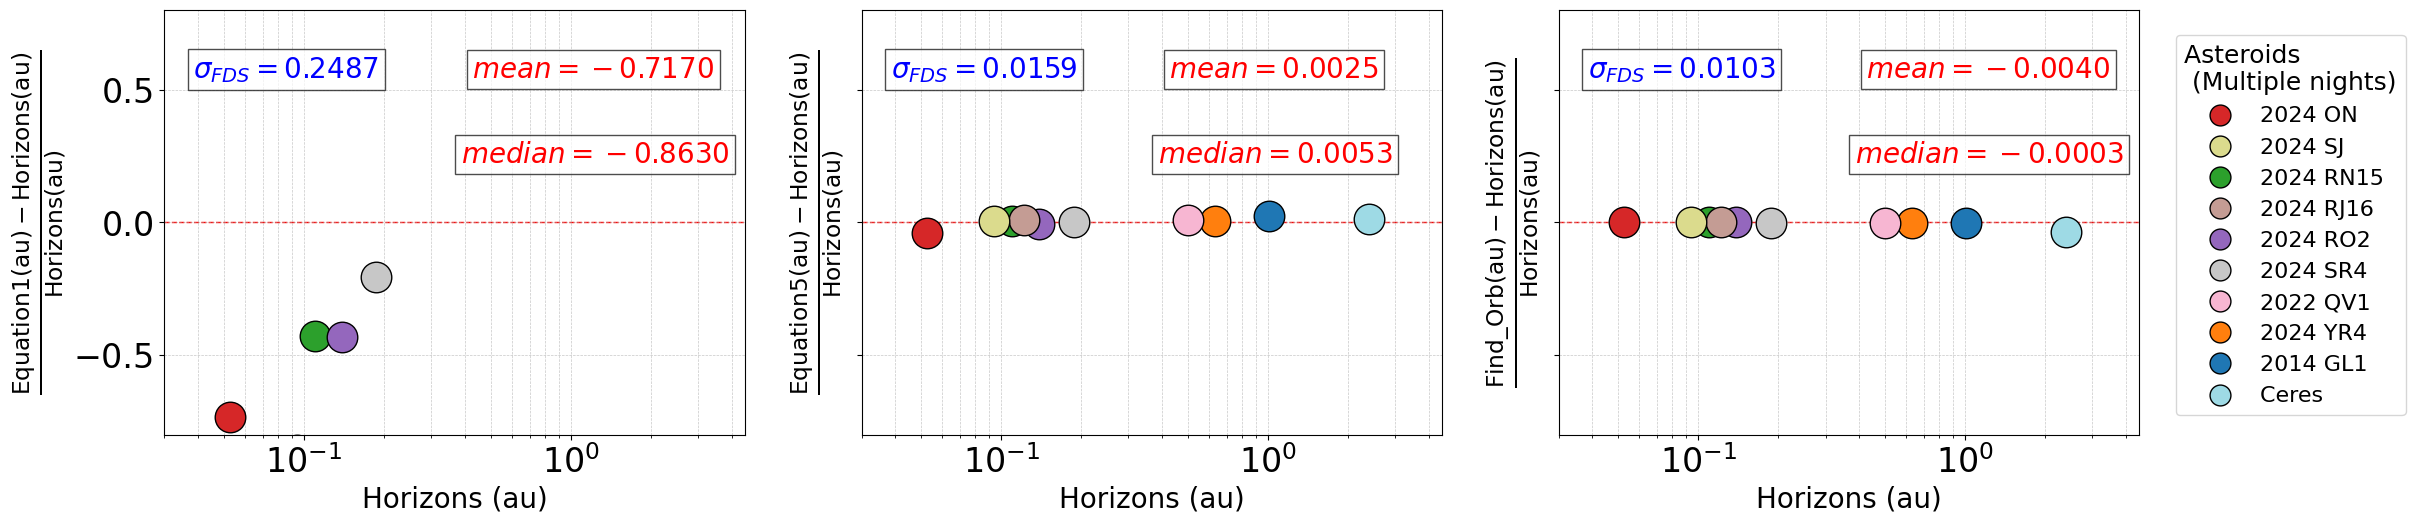

In [41]:
fig = plt.figure(figsize=(25, 5))
gs = GridSpec(
    1, 3,
    width_ratios=[1, 1, 1],
    height_ratios=[1.5])

colors = plt.cm.tab20(np.linspace(0, 1, len(results_df)))

# ================================================================================================================================

# Bottom-left: Residuals for Linear fit
ax1 = plt.subplot(gs[0, 0])
for i, color in enumerate(colors):
    ax1.errorbar(
        true_values.iloc[i], residuals_lin.iloc[i], fmt='o',
        color=color, markersize=22, markeredgecolor='black', capsize=24, linewidth=2)
ax1.axhline(0, color='red', linestyle='--', linewidth=1, zorder=1)

ax1.text(0.05, 0.84, f"$\\sigma_{{FDS}} = {sigma_lin:.4f}$", fontsize=20, color='blue',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax1.transAxes)

ax1.text(0.53, 0.84, f"$mean = {lin_mean:.4f}$", fontsize=20, color='red',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax1.transAxes)

ax1.text(0.51, 0.64, f"$median = {lin_median:.4f}$", fontsize=20, color='red',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax1.transAxes)
ax1.set_xlim(0.03, 4.5)
ax1.set_xscale('log')
ax1.set_ylim(-0.8, 0.8)
ax1.set_yscale('linear') 
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax1.tick_params(axis='both', which='major', labelsize=24)
ax1.set_ylabel(r'$\frac{\mathrm{Equation 1 (au)} - \mathrm{Horizons (au)}}{\mathrm{Horizons (au)}}$', fontsize=24)
ax1.set_xlabel('Horizons (au)', fontsize = 20)

# Bottom-left: Residuals for Linear fit
ax2 = plt.subplot(gs[0, 2])

for i, color in enumerate(colors):
    ax2.errorbar(true_values.iloc[i], residuals_Horizon_FindOrb.iloc[i], fmt='o', color=color, markersize=22, markeredgecolor='black', capsize=24, linewidth=2)

ax2.axhline(0, color='red', linestyle='--', linewidth=1, zorder=1)

ax2.text(0.05, 0.84, f"$\\sigma_{{FDS}} = {sigma_Horizon_FindOrb:.4f}$", fontsize=20, color='blue', bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax2.transAxes)

ax2.text(0.53, 0.84, f"$mean = {Horizon_FindOrb_mean:.4f}$", fontsize=20, color='red',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax2.transAxes)

ax2.text(0.51, 0.64, f"$median = {Horizon_FindOrb_median:.4f}$", fontsize=20, color='red',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax2.transAxes)

ax2.set_xlim(0.03, 4.5)
ax2.set_xscale('log')
ax2.set_ylim(-0.8, 0.8)
ax2.set_yscale('linear')
ax2.set_yticklabels([])
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax2.set_ylabel(r'$\frac{\mathrm{Find\_Orb (au)} - \mathrm{Horizons (au)}}{\mathrm{Horizons (au)}}$', fontsize=24)
ax2.tick_params(axis='both', which='major', labelsize=24)
ax2.set_xlabel('Horizons (au)', fontsize = 20)

# Bottom-right: Residuals for Polynomial fit
ax3 = plt.subplot(gs[0, 1])
for i, color in enumerate(colors):
    ax3.errorbar(true_values.iloc[i], residuals_poly.iloc[i], fmt='o', color=color, markersize=22, markeredgecolor='black', capsize=24, linewidth=2)
ax3.axhline(0, color='red', linestyle='--', linewidth=1, zorder=1)

ax3.text(0.05, 0.84, f"$\\sigma_{{FDS}} = {sigma_poly:.4f}$", fontsize=20, color='blue',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax3.transAxes)

ax3.text(0.53, 0.84, f"$mean = {poly_mean:.4f}$", fontsize=20, color='red',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax3.transAxes)

ax3.text(0.51, 0.64, f"$median = {poly_median:.4f}$", fontsize=20, color='red',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax3.transAxes)
ax3.set_xticklabels([])
ax3.set_xlim(0.03, 4.5)
ax3.set_xscale('log')
ax3.set_ylim(-0.8, 0.8)
ax3.set_yscale('linear')
ax3.set_yticklabels([])
ax3.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax3.tick_params(axis='both', which='major', labelsize=24)
ax3.set_ylabel(r'$\frac{\mathrm{Equation 5 (au)} - \mathrm{Horizons (au)}}{\mathrm{Horizons (au)}}$', fontsize=24)
ax3.set_xlabel('Horizons (au)', fontsize = 20)

# --- Linear residuals ---
#ax1.set_title("Residuals: Equation 1 (Linear)", fontsize=24, pad=20)

# --- Polynomial residuals ---
#ax3.set_title("Residuals: Equation 5 (Polynomial)", fontsize=24, pad=20)

# --- Find_Orb residuals ---
#ax2.set_title("Residuals: Find_Orb vs Horizons", fontsize=24, pad=20)

#----------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------

# Sorting Asteroid distance in legend
if isinstance(true_values, pd.Series):
    results_df['Mean Delta'] = true_values
else:
    results_df['Mean Delta'] = true_values.mean(axis=1)

sorted_indices = results_df['Mean Delta'].values.argsort()
sorted_file_names = results_df['File Name'].iloc[sorted_indices]
sorted_deltas = results_df['Mean Delta'].iloc[sorted_indices]
colors = np.array(colors)
sorted_colors = colors[sorted_indices]

max_name_length = max(len(file_name.replace('.csv', '')) for file_name in sorted_file_names)
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
           markeredgecolor='black', markersize=15,
           label=f"{file_name.replace('.csv', '').ljust(max_name_length)}")
           for file_name, delta, color in zip(sorted_file_names, sorted_deltas, sorted_colors)]

fig.legend(handles=handles, loc='center left', bbox_to_anchor=(0.85, 0.5), fontsize=16,
           title="Asteroids \n (Multiple nights)", title_fontsize=18, frameon=True)

plt.subplots_adjust(left=0.05, right=0.84, top=0.93, bottom=0.08, wspace=0.20, hspace=0.05)

plt.savefig("Figure 8 (row 2).png", format="png", dpi=300, bbox_inches="tight")
plt.show()


##### Step 20: Convert the Horizons ephemeris data into Find_Orb compatible .obs file. 

In [42]:
# The following constants define the Minor Planet Center (MPC) fixed-column format.
COL_DATE = 14   # Column where the date string starts: "CYYYY MM DDD.ddddd" (17 characters)
COL_RA   = 32   # Column where RA starts: "HH MM SS.ss" (11 characters)
COL_DEC  = 47   # Column where DEC starts: "+DD MM SS.s" (11 characters)
COL_OBS  = 77   # Column where the observatory code starts (3 characters)
LINE_LEN = 80   # Each MPC observation line must be exactly 80 characters long

def _put_at(buf, text, col_start_1based):
    # Inserts a string into a character buffer at a fixed 1-based column position.
    i = col_start_1based - 1          # 1-based column index converted to 0-based index.
    buf[i:i+len(text)] = list(text)   # buffer characters overwritten with the given text

def _ra_hms(ra_deg, prec=6):
    # RA in the Horizons file is converted from degrees to hours-minutes-seconds (HMS) for Find_Orb. 
    return Angle(float(ra_deg)*u.deg).to_string(
        unit=u.hour,                  # degrees → hours
        sep=' ',                      # HMS seperated with spaces
        precision=prec,               # Number of decimal places for seconds
        pad=True                      # Pad with leading zeros
    )

def _dec_dms(dec_deg, prec=5):
    # DEC in the Horizons file is converted from degrees to signed degrees-minutes-seconds (DMS) for Find_Orb.
    s = Angle(float(dec_deg)*u.deg).to_string(
        unit=u.deg,                   # units in degrees
        sep=' ',                      # DMS seperated with spaces
        precision=prec,               # Number of decimal places for arcseconds
        pad=True,                     # Pad with leading zeros
        alwayssign=True               # Always include + or - sign
    )
    return ' '.join(s.split())        # Normalize spacing to single spaces

def _date_from_jd(jd_utc):
    # Converts Julian Date (UTC) to MPC format
    t  = Time(float(jd_utc), format='jd', scale='utc')  # Create Astropy Time
    dt = t.to_datetime()                                # Convert to Python datetime

    # Compute fractional day required by MPC format
    day_frac = dt.day + (dt.hour + dt.minute / 60 + dt.second / 3600 + dt.microsecond / 1e6 / 3600) / 24.0

    # date formatted as: CYYYY MM DDD.ddddd
    return f"C{dt.year:04d} {dt.month:02d} {day_frac:08.5f}"

# Builds the single 80-character MPC observation line
def _format_line(jd, ra_deg, dec_deg, observatory='807'):

    # Initialize blank 80-character buffer
    line = [' '] * LINE_LEN          

    date_str = _date_from_jd(jd)                   # MPC-formatted date (17 chars)
    ra_str   = _ra_hms(ra_deg, prec=6).rjust(11)   # RA formatted and right-justified
    dec_str  = _dec_dms(dec_deg, prec=5).rjust(11) # Dec formatted and right-justified
    obs_str  = f"{observatory:>3}"                 # Observatory code, right-justified

    # Insert formatted fields into fixed MPC columns
    _put_at(line, date_str, COL_DATE)
    _put_at(line, ra_str,   COL_RA)
    _put_at(line, dec_str,  COL_DEC)
    _put_at(line, obs_str,  COL_OBS)

    # Convert character buffer to string
    return ''.join(line)             

def _normalize_cols(cols):
    # Normalizes DataFrame column names to avoid hidden Unicode / spacing issues. 
    fixed = []
    for c in cols:
        s = unicodedata.normalize('NFKC', str(c))  # Normalize Unicode characters
        s = s.replace('\u00A0', ' ')               # Replace non-breaking spaces
        s = ' '.join(s.split())                    # Collapse multiple spaces
        s = s.strip()                              # Remove leading/trailing spaces
        fixed.append(s)
    return fixed

# output directory for .obs files
formatted_folder  = os.path.join(asteroids_folder, "formatted_obs")
os.makedirs(formatted_folder, exist_ok=True)

# Loop over all .csv files in the folder. 
for fn in os.listdir(asteroids_folder):
    # Files with .csv extensions are skipped. 
    if not fn.lower().endswith(".csv"):
        continue                                 

    path = os.path.join(asteroids_folder, fn)
    df = pd.read_csv(path)                       

    # Normalize column names to avoid parsing issues
    df.columns = _normalize_cols(df.columns)

    # Drop any completely blank column names
    blank_cols = [c for c in df.columns if c == ""]
    if blank_cols:
        df = df.drop(columns=blank_cols)

    try:
        # Expected column names
        jd_col  = 'Date__(UT)__HR:MN'
        ra_col  = 'R.A.__(ICRF)'
        dec_col = 'DEC__(ICRF)'

        # Fallback search if RA column name does not match exactly
        if ra_col not in df.columns:
            candidates = [c for c in df.columns if 'R.A.' in c or 'RA' in c.upper()]
            if candidates:
                ra_col = candidates[0]
            else:
                raise KeyError("RA column not found after normalization.")

        # Fallback search if Dec column name does not match exactly
        if dec_col not in df.columns:
            candidates = [c for c in df.columns if 'DEC' in c.upper()]
            if candidates:
                dec_col = candidates[0]
            else:
                raise KeyError("DEC column not found after normalization.")

        # Convert columns to numeric values
        jd  = pd.to_numeric(df[jd_col],  errors="coerce")
        ra  = pd.to_numeric(df[ra_col],  errors="coerce")
        dec = pd.to_numeric(df[dec_col], errors="coerce")

        # Keep only rows with valid numeric JD, RA, Dec
        w   = pd.DataFrame({"jd": jd, "ra": ra, "dec": dec}).dropna()

        if w.empty:
            print(f"No numeric rows in {fn}; skipped.")
            continue

        # Format each row into MPC .obs line
        lines = [
            _format_line(jd, ra, dec, observatory="807")
            for jd, ra, dec in w[["jd","ra","dec"]].itertuples(index=False, name=None)]

        # Output file set as .obs file extension. 
        out = os.path.join(formatted_folder, f"{os.path.splitext(fn)[0]}.obs")
        with open(out, "w") as f:
            f.write("\n".join(lines) + "\n")
        print(f"Saved {out}")

    # Catch and report errors
    except Exception as e:
        print(f"Error in {fn}: {e}\nColumns seen: {list(df.columns)}")

Saved /hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/extracted_files/with_uncertainties/formatted_obs/2014 GL1.obs
Saved /hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/extracted_files/with_uncertainties/formatted_obs/2024 YR4.obs
Saved /hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/extracted_files/with_uncertainties/formatted_obs/2024 RN15.obs
Saved /hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/extracted_files/with_uncertainties/formatted_obs/2024 ON.obs
Saved /hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/extracted_files/with_uncertainties/formatted_obs/2024 RO2.obs
Saved /hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/extracted_files/with_uncertainties/formatted_obs/2024 RJ16.obs
Saved /hpc/home/mf342/Maryann et al. 2025/Figure 8/Multiple night/csv_files/extracted_files/with_uncertainties/formatted_obs/2022 QV1.obs
Saved /hpc/home/mf342/Maryann et 

##### Step 21: Print all the observations in MPC format. 

In [44]:
# Print all MPC-formatted data from all .obs files
for file_name in sorted(os.listdir(formatted_folder)):
    if file_name.endswith('.obs'):
        print(f"\n📄 {file_name}")
        
        with open(os.path.join(formatted_folder, file_name), 'r') as f:
            print(f.read())


📄 2014 GL1.obs
             C2024 09 05.00000 16 41 46.030192-28 53 25.57452               807 
             C2024 09 05.12500 16 41 48.625544-28 52 54.04906               807 
             C2024 09 05.96875 16 42 09.790615-28 49 39.92686               807 
             C2024 09 06.00000 16 42 10.489133-28 49 32.47440               807 
             C2024 09 06.03125 16 42 11.195250-28 49 24.95441               807 
             C2024 09 06.06250 16 42 11.921599-28 49 17.30955               807 
             C2024 09 07.06250 16 42 39.267227-28 45 30.85726               807 
             C2024 09 07.09375 16 42 40.096392-28 45 23.26851               807 
             C2024 09 07.12500 16 42 40.948104-28 45 15.67870               807 
             C2024 09 08.03125 16 43 08.372055-28 41 57.70082               807 
             C2024 09 08.06250 16 43 09.268800-28 41 50.41715               807 
             C2024 09 08.09375 16 43 10.182151-28 41 43.03029               807 
            